In [2]:
#!pip install --upgrade tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 85.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 93.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 38.2 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [1]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

3.4.1
2.17.0


## Librerias:

In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from io import StringIO

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Embedding, Dropout, Input, TimeDistributed, CategoryEncoding, SimpleRNN, GRU
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


# descargar de textos.info
import urllib.request
# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

## Modelo de lenguaje con tokenización por caracteres

#### Datos  


In [ ]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/viaje-al-centro-de-la-tierra/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [ ]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' el domingo 24 de mayo de 1863, mi tío, el profesor lidenbrock, entró \r\nrápidamente a su hogar, situado en el número 19 de la könig‑strasse, una\r\n de las calles más tradicionales del barrio antiguo de hamburgo. marta, su excelente criada, se preocupó sobremanera, creyendo que se \r\nhabía retrasado, pues apenas empezaba a cocinar la comida en el \r\nhornillo. “bueno” —pensé para mí—, “si mi tío viene con hambre, se va a armar \r\nla de san quintín; porque no conozco a otro hombre de menos paciencia”. —¡tan temprano y ya está aquí el señor lidenbrock! —exclamó la pobre marta, con arrebol, entreabriendo la puerta del comedor. —sí, marta; pero tú no tienes la culpa de que la comida no esté lista\r\n todavía, porque es temprano, aún no son las dos. acaba de dar la media \r\nhora en san miguel. —¿y por qué ha venido tan pronto el señor lidenbrock? —él lo explicará, seguramente. —¡ahí viene! yo me escapo. señor axel, cálmelo usted, por favor. y la excelente marta se retiró presurosa a s

#### Tamaño de contexto

In [ ]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [ ]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

vocab_size = len(chars_vocab)

print("La longitud de vocabulario de caracteres es: ", vocab_size)

La longitud de vocabulario de caracteres es:  78


In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

#### Tokenizamos

In [ ]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]
tokenized_text[:10]

[39, 31, 33, 39, 28, 6, 2, 37, 74, 52]

#### Organizando y estructurando el dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

print(f"Tenemos {num_val} secuencias de tamaño {max_context_size} que se usaran para la validación")

Tenemos 433 secuencias de tamaño 100 que se usaran para la validación


In [ ]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

# tokenizamos en sentencias de largo 100
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

# features y target:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

#### Callback para calculo de perplejidad

In [ ]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl,patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


#### Definir modelo

In [ ]:
model = Sequential()

model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model.add(SimpleRNN(200, return_sequences=True, dropout=0.1, recurrent_dropout=0.1 ))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 78)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 200)           │          55,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 78)            │          15,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,478 (279.21 KB)

 Trainable params: 71,478 (279.21 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos

In [ ]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=16384)

perplexity_list_1 = history_ppl

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - loss: 3.5571
 mean perplexity: 20.02914976578146 

Saved new model!
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - loss: 3.5446  
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 3.0048
 mean perplexity: 18.04132923782415 

Saved new model!
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 3.0038  
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - loss: 2.8854
 mean perplexity: 15.621792186557581 

Saved new model!
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - loss: 2.8841  
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 2.7610
 mean perplexity: 13.743796638652878 

Saved new model!
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - loss: 2.7598  
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - loss: 2.6388
 mean perplexity: 12.427481159409016 

Saved new model!
24/24 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 2.6379  
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - loss: 2.5456
 mean perplexity: 11.386181310309947 

S

In [ ]:
# Usamos esta linea solo si la ultima epoca guarda el modelo, esto lo usamos porque teniamos problemas con colab,
# le tomaba tiempo actualizarse
model.save("SimpleRNN.keras")

In [ ]:
print(perplexity_list_1)

[20.02914976578146, 18.04132923782415, 15.621792186557581, 13.743796638652878, 12.427481159409016, 11.386181310309947, 10.688926708342418, 10.184589714234036, 9.771008856049852, 9.536901048001397, 9.380329222730806, 9.121821766075083, 9.026320820045125, 8.905021414377655, 8.794400398313503, 8.710237897645703, 8.58887610588463, 8.480964774947264, 8.40104061040319, 8.318892663826514]


#### Modelo 2:

In [ ]:
model2 = Sequential()

model2.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model2.add(LSTM(200, return_sequences=True, dropout=0.1))
model2.add(Dense(vocab_size, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_1 (TimeDistributed) │ (None, None, 78)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 200)           │         223,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 78)            │          15,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 238,878 (933.12 KB)

 Trainable params: 238,878 (933.12 KB)

 Non-trainable params: 0 (0.00 B)

 Entrenamos:

In [ ]:
history_ppl = []
hist2 = model2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=8192)

perplexity_list_2 = history_ppl

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - loss: 3.5220
 mean perplexity: 20.68889511647354 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - loss: 3.5160  
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - loss: 3.0389
 mean perplexity: 19.75762426797962 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 3.0386  
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - loss: 2.9828
 mean perplexity: 18.613299896135377 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - loss: 2.9825  
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - loss: 2.9069
 mean perplexity: 17.090482341632057 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - loss: 2.9064  
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - loss: 2.8095
 mean perplexity: 15.418599381269527 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - loss: 2.8090  
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 726ms/step - loss: 2.7152
 mean perplexity: 14.24596291133006 

Sa

In [ ]:
# Usamos esta linea solo si la ultima epoca guarda el modelo, esto lo usamos porque teniamos problemas con colab,
# le tomaba tiempo actualizarse
model2.save("LSTM.keras")

In [ ]:
print(perplexity_list_2)

[20.68889511647354, 19.75762426797962, 18.613299896135377, 17.090482341632057, 15.418599381269527, 14.24596291133006, 13.427348432593316, 12.71785097973829, 12.354503224948756, 11.818124309276662, 11.564008266401649, 11.309113425177868, 11.12071240270406, 10.863377449969766, 10.734161990584969, 10.490128056791509, 10.361983864882935, 10.370224303180011, 10.241340417371102, 10.09892207886922]


#### Modelo 3:

In [ ]:
model3 = Sequential()

model3.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode = "one_hot"),input_shape=(None,1)))
model3.add(GRU(200, return_sequences=True, dropout=0.1))
model3.add(Dense(vocab_size, activation='softmax'))
model3.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_2 (TimeDistributed) │ (None, None, 78)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 200)           │         168,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 78)            │          15,678 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,678 (717.49 KB)

 Trainable params: 183,678 (717.49 KB)

 Non-trainable params: 0 (0.00 B)

Entrenamos

In [ ]:
history_ppl = []
hist3 = model3.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=8192)

perplexity_list_3 = history_ppl

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - loss: 3.6323
 mean perplexity: 19.549728461865083 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - loss: 3.6248  
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 2.9443
 mean perplexity: 15.886486519612722 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 48s 1000ms/step - loss: 2.9432
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - loss: 2.7091
 mean perplexity: 13.010336107515194 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 82s 992ms/step - loss: 2.7080
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - loss: 2.5302
 mean perplexity: 11.810264389333359 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 881ms/step - loss: 2.5297
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - loss: 2.4334
 mean perplexity: 10.86768494275116 

Saved new model!
48/48 ━━━━━━━━━━━━━━━━━━━━ 83s 908ms/step - loss: 2.4331
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - loss: 2.3706
 mean perplexity: 10.4399438539747

In [ ]:
# Usamos esta linea solo si la ultima epoca guarda el modelo, esto lo usamos porque teniamos problemas con colab,
# le tomaba tiempo actualizarse
model3.save("GRU.keras")

In [ ]:
print(perplexity_list_3)

[19.549728461865083, 15.886486519612722, 13.010336107515194, 11.810264389333359, 10.86768494275116, 10.439943853974723, 10.120099534477893, 9.851243831434605, 9.698832019203593, 9.425193053304278, 9.258547080243854, 8.989844616571666, 8.854276997194564, 8.71635208919501, 8.540555583311265, 8.393212366275302, 8.283242850805177, 8.119826616140038, 8.069211880338885, 7.914010618652463]


#### Graficamos los resultados de los 3 modelos

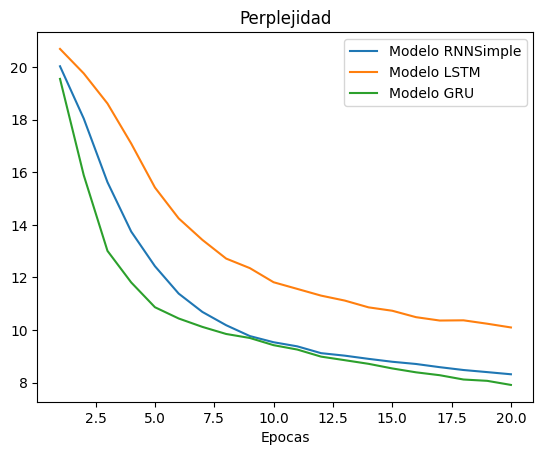

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Almacenamos los valores que nos dieron los modelos, por las dudas que se borre el grafico:
#perplexity_list_1 = [18.35348292625756, 14.187752989681718, 11.68172333920293, 10.278628417581865, 9.580095976873961, 9.199486572602078, 8.931407086413582, 8.729456669547432, 8.578930348969283, 8.373003908518504, 8.198234107899633, 8.054698518038485, 7.891941727339655, 7.769069659406207, 7.627919621707685, 7.553985045875523, 7.409860972855947, 7.268622614500832, 7.229433832619077, 7.069846422047101]
#perplexity_list_2 = [20.61363693085816, 19.656826509622334, 18.033396838609324, 16.017221566046533, 14.879777497885168, 13.43484101889667, 12.725657355007364, 12.256889772490362, 11.675434830384688, 11.328046822295747, 10.976125735601128, 10.819554920491584, 10.492334302850013, 10.317576014390266, 10.246430554214315, 10.076789447217726, 10.214063552045506, 9.862235899765345, 9.85112511563387, 9.656010732107136]
#perplexity_list_3 = [19.290295231783922, 15.578869259424819, 12.904899738020406, 11.725154464538665, 10.958383356161615, 10.494092470839224, 10.262721613826823, 10.040607718683363, 9.716731513589659, 9.535563775367702, 9.410284661869618, 9.213353837530098, 9.019896203873866, 8.869359521182103, 8.734476115309656, 8.593534171308933, 8.52806181788598, 8.306512902926164, 8.269092161806658, 8.078397891767453]

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=perplexity_list_1, label="Modelo RNNSimple")
sns.lineplot(x=epoch_count,  y=perplexity_list_2, label="Modelo LSTM")
sns.lineplot(x=epoch_count,  y=perplexity_list_3, label="Modelo GRU")
plt.title("Perplejidad")
plt.xlabel("Epocas")
plt.show()

![grafico_caracteres.png](grafico_caracteres.png)

Cargamos los modelos

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
SimpleRNN = keras.models.load_model('SimpleRNN.keras')
GRU_model = keras.models.load_model('GRU.keras')
LSTM_model = keras.models.load_model('LSTM.keras')

In [ ]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

3.4.1
2.17.0


En colab, los modelos fueron entrenador en las versiones:  
- keras==2.15.0  
- tensorflow==2.15.0  

De aca vienen los problemas al cargar los modelos:  
- ValueError: Unrecognized keyword arguments passed to TimeDistributed: {'batch_input_shape': [None, None, 1]}

#### Generación de secuencias:

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text = 'nos aventuramos en las profundidades de la tierra, donde descubrimos'

print("SimpleRNN result: ", generate_seq(SimpleRNN, input_text, max_length=max_context_size, n_words=30))
print("LSTM result: ", generate_seq(LSTM_model, input_text, max_length=max_context_size, n_words=30))
print("GRU result: ", generate_seq(GRU_model, input_text, max_length=max_context_size, n_words=30))

SimpleRNN result:  nos aventuramos en las profundidades de la tierra, donde descubrimos de las antera de la minte de 
LSTM result:  nos aventuramos en las profundidades de la tierra, donde descubrimos de la la la la la la la la la
GRU result:  nos aventuramos en las profundidades de la tierra, donde descubrimos de  asta de la minto de la co


####  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    # Asigna un índice especial para caracteres desconocidos
    unknown_char_idx = char2idx.get('<UNK>', 0)

    encoded = [char2idx.get(ch, unknown_char_idx) for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    #encoded = [char2idx[ch] for ch in text]
    #encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [ ]:
# predicción con beam search
sentence = 'nos aventuramos en las profundidades de la tierra, donde descubrimos'
# veamos las salidas
print(decode(beam_search(SimpleRNN,num_beams=10,num_words=20,input=sentence)[0]))
print(decode(beam_search(LSTM_model,num_beams=10,num_words=20,input=sentence)[0]))
print(decode(beam_search(GRU_model,num_beams=10,num_words=20,input=sentence)[0]))

âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos que había de las 

âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos de lastras de los  
âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos de las había de las


Probamos el estocastico cambiando la temperatura

In [ ]:
temp = [0.1, 0.4, 0.7, 1]
sentence = 'nos aventuramos en las profundidades de la tierra, donde descubrimos'
for t in temp:
    print(f"Estocastico con temperatura: {t}")
    print("SimpleRNN: ", decode(beam_search(SimpleRNN,num_beams=10,num_words=20,input=sentence)[0]))
    print("LSTM_model: ", decode(beam_search(LSTM_model,num_beams=10,num_words=20,input=sentence)[0]))
    print("GRU_model: ", decode(beam_search(GRU_model,num_beams=10,num_words=20,input=sentence)[0]))

Estocastico con temperatura: 0.1
SimpleRNN:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos que había de las 

LSTM_model:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos ententa de la la la
GRU_model:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos que con los 
conte
Estocastico con temperatura: 0.4
SimpleRNN:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos que había de las 

LSTM_model:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos de labra de los de 
GRU_model:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde descubrimos que las compera de 
Estocastico con temperatura: 0.7
SimpleRNN:  âââââââââââââââââââââââââââââââânos aventuramos en las profundidades de la tierra, donde des

## Modelo de lenguaje con tokenización por palabras

#### Datos

In [28]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [29]:
# Posibles bandas
os.listdir("./songs_dataset/")

['joni-mitchell.txt',
 'lil-wayne.txt',
 'beatles.txt',
 'paul-simon.txt',
 'disney.txt',
 'dr-seuss.txt',
 'johnny-cash.txt',
 'bruno-mars.txt',
 'eminem.txt',
 'bruce-springsteen.txt',
 'ludacris.txt',
 'nirvana.txt',
 'prince.txt',
 'jimi-hendrix.txt',
 'kanye.txt',
 'rihanna.txt',
 'patti-smith.txt',
 'r-kelly.txt',
 'britney-spears.txt',
 'missy-elliott.txt',
 'lady-gaga.txt',
 'nicki-minaj.txt',
 'blink-182.txt',
 'lin-manuel-miranda.txt',
 'adele.txt',
 'bob-marley.txt',
 'drake.txt',
 'dolly-parton.txt',
 'dj-khaled.txt',
 'janisjoplin.txt',
 'bjork.txt',
 'Lil_Wayne.txt',
 'dickinson.txt',
 'nickelback.txt',
 'lorde.txt',
 'bob-dylan.txt',
 'al-green.txt',
 'alicia-keys.txt',
 'Kanye_West.txt',
 'michael-jackson.txt',
 'notorious-big.txt',
 'bieber.txt',
 'amy-winehouse.txt',
 'kanye-west.txt',
 'nursery_rhymes.txt',
 'radiohead.txt',
 'cake.txt',
 'leonard-cohen.txt',
 'notorious_big.txt']

In [30]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)
df.head()

<ipython-input-30-91c4bad52ba1>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/beatles.txt', sep='/n', header=None)


,0
0,"Yesterday, all my troubles seemed so far away"
1,Now it looks as though they're here to stay
2,"Oh, I believe in yesterday Suddenly, I'm not h..."
3,There's a shadow hanging over me.
4,"Oh, yesterday came suddenly Why she had to go ..."


#### Elegimos el tamaño del contexto

(array([ 29., 305., 221., 523., 293.,  72., 180.,  97.,  42.,  39.,  22.,
         12.,   4.,   3.,   0.,   0.,   2.,   1.,   0.,   1.]),
 array([ 1.  ,  2.65,  4.3 ,  5.95,  7.6 ,  9.25, 10.9 , 12.55, 14.2 ,
        15.85, 17.5 , 19.15, 20.8 , 22.45, 24.1 , 25.75, 27.4 , 29.05,
        30.7 , 32.35, 34.  ]),
 <BarContainer object of 20 artists>)

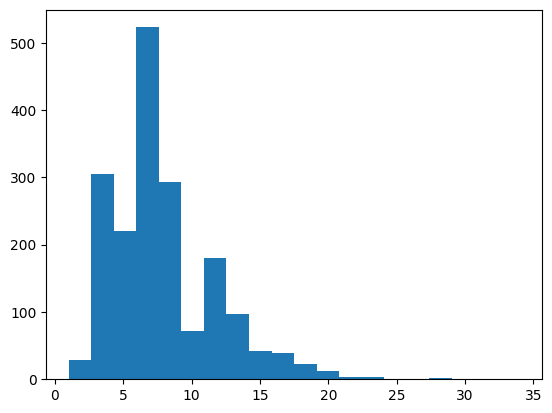

In [31]:
# cada frase la guardamos en una lista
text = list(df.loc[:,0])

# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

# podemos ver su distribución
plt.hist(length_sentences,bins=20)

![distribucion_contexto_palabras.png](distribucion_contexto_palabras.png)

In [32]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
# max_context_size = int(np.ceil(np.median(length_sentences))) # criterio de mediana
print(f'max_context_size: {max_context_size}')

max_context_size: 12


#### Tokenizamos

In [33]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

print(f"Frase: {segmented_sentences[0]}, tokenización: {tokenized_sentences[0]}")

Frase: ['yesterday', 'all', 'my', 'troubles', 'seemed', 'so', 'far', 'away'], tokenización: [200, 10, 12, 907, 908, 42, 909, 121]


#### Organizando y estructurando el dataset

In [34]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Spliteamos las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento

In [35]:
print(f"Secuencias de entrenamientos antes del spliteo: {len(tokenized_sentences_train)}")

Secuencias de entrenamientos antes del spliteo: 1476


In [36]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [37]:
print(f"Secuencias de entrenamientos despues del spliteo: {len(tok_sent)}")

Secuencias de entrenamientos despues del spliteo: 1957


Padeamos

In [38]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [39]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [40]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [41]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

1628

#### CallBack para la perplejidad

In [42]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model_word.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


#### MODELO 1

In [43]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, None, 50)            │          81,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, None, 1629)          │         164,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 386,779 (1.48 MB)

 Trainable params: 386,779 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento

In [44]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

perplexity_list_1 = history_ppl

Epoch 1/20
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.4982
 mean perplexity: 1434.2108862658442 

Saved new model!
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 4.4798
Epoch 2/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.0470
 mean perplexity: 1610.6598093382152 

240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 3.0471
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.0237
 mean perplexity: 1610.7659716622527 

240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 3.0236
Epoch 4/20
234/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9351
 mean perplexity: 1822.9651999403895 

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.9349
Epoch 5/20
233/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8816
 mean perplexity: 1953.3287680765281 

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8810
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8093
 mean perplexity: 2071.9168806093107 

Stopping training...
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/ste

#### modelo 2:

In [46]:
model2 = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model2.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model2.add(SimpleRNN(100, return_sequences=True))
# model.add(Dropout(0.2))

model2.add(SimpleRNN(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model2.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, None, 50)            │          81,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, None, 100)           │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, None, 1629)          │         164,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,179 (1.07 MB)

 Trainable params: 281,179 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento:

In [47]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model2.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

perplexity_list_2 = history_ppl

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0526
 mean perplexity: 1351.4841659181614 

Saved new model!
240/240 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 4.0498
Epoch 2/20
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9292
 mean perplexity: 2031.8111518233063 

240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 2.9281
Epoch 3/20
237/240 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6940
 mean perplexity: 2145.0359764829295 

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.6934
Epoch 4/20
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5249
 mean perplexity: 2140.983150960548 

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 2.5244
Epoch 5/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3825
 mean perplexity: 1624.6243237842575 

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.3821
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1892
 mean perplexity: 2248.1564844126324 

Stopping training...
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

#### Modelo 3:

In [49]:
model3 = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model3.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model3.add(GRU(100, return_sequences=True))
# model.add(Dropout(0.2))

model3.add(GRU(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model3.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model3.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, None, 50)            │          81,450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, None, 1629)          │         164,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,179 (1.34 MB)

 Trainable params: 352,179 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

#### Entrenamiento:

In [25]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model3.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

perplexity_list_3 = history_ppl

Epoch 1/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.1333
 mean perplexity: 1757.5873572678438 

Saved new model!
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 4.1240
Epoch 2/20
233/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9017
 mean perplexity: 3672.1843395084934 

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9010
Epoch 3/20
238/240 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.7650
 mean perplexity: 3523.343715581994 

240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.7644
Epoch 4/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6245
 mean perplexity: 2618.9858957079937 

240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.6242
Epoch 5/20
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5096
 mean perplexity: 3776.017871110226 

240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5093
Epoch 6/20
233/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4041
 mean perplexity: 2822.9075300546497 

Stopping training...
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - los

#### Graficamos

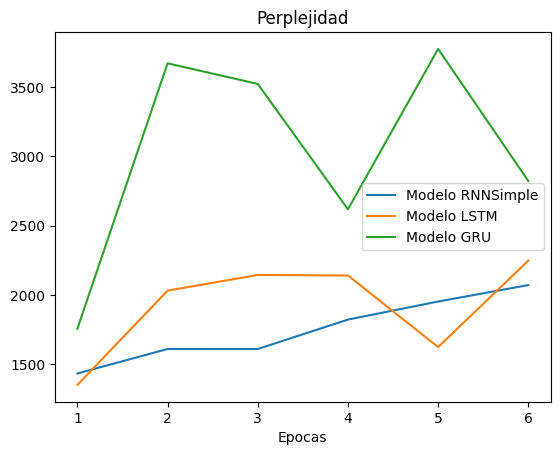

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=perplexity_list_1, label="Modelo RNNSimple")
sns.lineplot(x=epoch_count,  y=perplexity_list_2, label="Modelo LSTM")
sns.lineplot(x=epoch_count,  y=perplexity_list_3, label="Modelo GRU")
plt.title("Perplejidad")
plt.xlabel("Epocas")
plt.show()

![grafico_palabras.png](grafico_palabras.png)

In [ ]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
RNNSimple_word = keras.models.load_model('RNNSimple_word.keras')
LSTM_word = keras.models.load_model('LSTM_word.keras')
GRU_word = keras.models.load_model('GRU_word.keras')

#### Generación de secuencias

In [51]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [54]:
input_text = 'hey jude don\'t'

print(f"RNNSimpple: ", generate_seq(RNNSimple_word, tok, input_text, max_length=max_context_size, n_words=10))
print(f"GRU: ", generate_seq(GRU_word, tok, input_text, max_length=max_context_size, n_words=10))
print(f"LSTM: ", generate_seq(LSTM_word, tok, input_text, max_length=max_context_size, n_words=10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
RNNSimpple:  hey jude don't it's been a hard day's night i said be for
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
GRU:  hey jude don't you know i say i say i say i say
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


####  Beam search y muestreo aleatorio

In [55]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [56]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [57]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
temp = [0.1, 0.2, 0.5, 0.7, 1]

for t in temp:
    print("Temperatura: ", t)
    print("RNNSimple: ", decode(beam_search(RNNSimple_word,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')[0]))
    print("GRU_word: ", decode(beam_search(GRU_word,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')[0]))
    print("LSTM_word: ", decode(beam_search(LSTM_word,num_beams=10,num_words=6,input="when i find myself in times",temp=1,mode='sto')[0]))

Temperatura:  0.1
RNNSimple:  ['when i find myself in times of night if i never want']
GRU_word:  ['when i find myself in times a lot with the little help']
LSTM_word:  ['when i find myself in times in a taxman and you want']
Temperatura:  0.2
RNNSimple:  ['when i find myself in times there let you do too give']
GRU_word:  ["when i find myself in times there a hard day's night i"]
LSTM_word:  ['when i find myself in times to the and and i more']
Temperatura:  0.5
RNNSimple:  ['when i find myself in times in the lot me take you']
GRU_word:  ['when i find myself in times there in the night i had']
LSTM_word:  ['when i find myself in times and i no love you never']
Temperatura:  0.7
RNNSimple:  ['when i find myself in times and and the bath fill all']
GRU_word:  ['when i find myself in times of moment with the doors help']
LSTM_word:  ['when i find myself in times in and you nah you do']
Temperatura:  1
RNNSimple:  ['when i find myself in times of trouble blackbird comes a lorry']
GRU_wor